# Running and Calculating Synchrotron Radiation (3 GeV)
This notebook contains guidance on running notebooks and a physics section that computes synchrotron radiation loss and simple dipole magnet power estimates for 3 GeV electrons.

## 1) Install and launch Jupyter
Install Jupyter or JupyterLab if needed and start a server:
````
pip install jupyterlab
jupyter lab
````
Or classic UI:
````
pip install notebook
jupyter notebook
````

## 2) Open and run a notebook in VS Code
Open this `.ipynb` file in VS Code and use the Run Cell buttons or keyboard shortcuts. Example cell below.

In [59]:
# Example cell to try
print('Hello from cell')

Hello from cell


## 3) Run individual cells and selections
Select code and choose 'Run Selection/Line in Python Interactive Window' or use the Run Cell button. Example selection below.

In [60]:
for i in range(3):
    print(i)

0
1
2


## 4) Run all cells and restart kernel
Use 'Run All' or 'Restart Kernel and Run All Cells' from the notebook toolbar.
From terminal (non-interactive):
````
jupyter nbconvert --to notebook --execute mynotebook.ipynb --output executed.ipynb
````

## 5) Execute notebooks from the terminal / CI
Use `nbconvert` or `papermill` for headless execution (examples in comments).

## 6) Parameterize notebooks with papermill
Create a parameters cell tagged 'parameters' and use papermill to inject values. Example provided in docs.

## 7) Automate runs with GitHub Actions
Example workflow steps are given in the project README or earlier messages.

## 8) Use virtual environments and kernels
Create a venv and register an ipykernel for VS Code. Example commands are in the notebook header.

## 9) Debug a cell
Use VS Code's 'Debug Cell' action or `breakpoint()` in code.

## 10) Test notebooks with nbval
Use `pytest --nbval` or `--nbval-lax` for CI-friendly testing.

## 11) Export notebooks to script / HTML / PDF
Use `jupyter nbconvert --to script|html|pdf`.

## 12) Capture output and logs
Use logging or write outputs to files for CI artifacts.

---
# Physics: Synchrotron radiation and dipole-power estimates (3 GeV)
This code cell computes U0, radiated power for example currents, simple dipole B, coil current, coil resistive power and writes a CSV and plots results.

Results for E = 3.0 GeV
   R (m)   U0 (keV)      U0 (eV)      B (T)    Icoil Pmag(10mm2)W
     100     71.685      71685.0     0.1001    31.85        535.5
    1000      7.168       7168.5     0.0100     3.19         53.6
   10000      0.717        716.9     0.0010     0.32          5.4

CSV saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\synchrotron_calc_results.csv
Plots saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\U0_vs_R.png and c:\Users\benfol\Documents\LW_windows\LW_integrator\Pmag_vs_R.png
Plots saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\U0_vs_R.png and c:\Users\benfol\Documents\LW_windows\LW_integrator\Pmag_vs_R.png


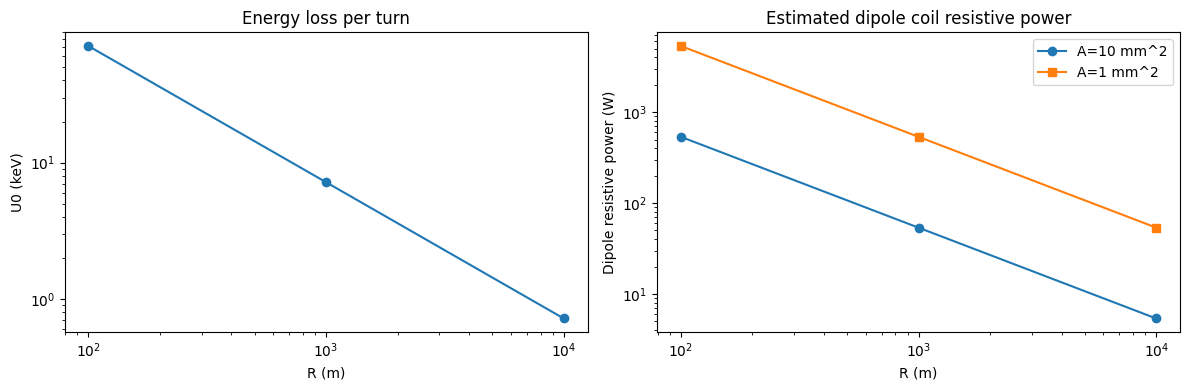

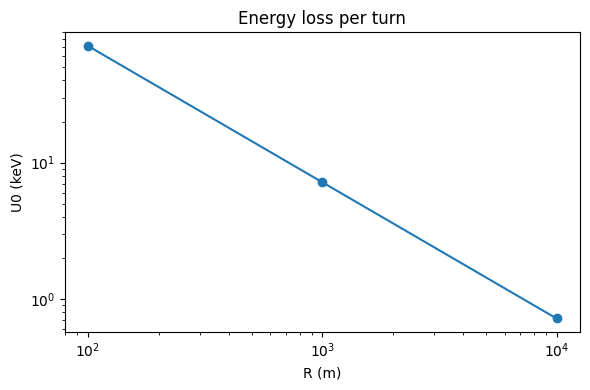

In [61]:
# Compute and plot U0 and simple magnet power estimates for 3 GeV electrons
import os
import numpy as np
import math
import csv
import matplotlib.pyplot as plt

# Parameters
E_GeV = 3.0
R_list = np.array([100.0, 1000.0, 10000.0])  # meters
currents = [1e-6, 1e-3, 1.0]  # A: 1 uA, 1 mA, 1 A

# Constants
keV_factor = 88.5  # U0[keV] = 88.5 * E^4 / R
eV_per_keV = 1e3
e_charge = 1.602176634e-19  # C
mu0 = 4*math.pi*1e-7
c = 299792458.0

# Magnet assumptions
g = 0.04  # magnet gap [m]
N_turns = 100
A_cu_examples = [1e-5, 1e-6]  # m^2 (10 mm^2, 1 mm^2)
rho_cu = 1.68e-8  # ohm*m
f_dip = 0.5  # fraction of circumference occupied by dipoles

# Prepare results
rows = []
for R in R_list:
    U0_keV = keV_factor * E_GeV**4 / R
    U0_eV = U0_keV * eV_per_keV
    U0_J = U0_eV * e_charge
    # Radiated power for example currents
    P_rad = [I * U0_eV for I in currents]
    P_rad_W = [p for p in P_rad]
    # Dipole field
    B = E_GeV / (0.299792458 * R)
    NI = B * g / mu0
    I_coil = NI / N_turns
    # Resistive power per meter for two conductor sizes
    R_per_m_list = [rho_cu / A for A in A_cu_examples]
    P_per_m_list = [I_coil**2 * R_per_m for R_per_m in R_per_m_list]
    L_dip = 2 * math.pi * R * f_dip
    P_mag_list = [P_per_m * L_dip for P_per_m in P_per_m_list]

    rows.append({
        'R_m': R,
        'U0_keV': U0_keV,
        'U0_eV': U0_eV,
        'U0_J': U0_J,
        'B_T': B,
        'NI_At': NI,
        'I_coil_A': I_coil,
        'P_rad_1uA_W': P_rad_W[0],
        'P_rad_1mA_W': P_rad_W[1],
        'P_rad_1A_W': P_rad_W[2],
        'P_mag_A10mm2_W': P_mag_list[0],
        'P_mag_A1mm2_W': P_mag_list[1],
    })

# Print a readable table
print('Results for E = {:.1f} GeV'.format(E_GeV))
print('{:>8} {:>10} {:>12} {:>10} {:>8} {:>8}'.format('R (m)','U0 (keV)','U0 (eV)','B (T)','Icoil','Pmag(10mm2)W'))
for r in rows:
    print('{:8.0f} {:10.3f} {:12.1f} {:10.4f} {:8.2f} {:12.1f}'.format(
        r['R_m'], r['U0_keV'], r['U0_eV'], r['B_T'], r['I_coil_A'], r['P_mag_A10mm2_W']))

# Save CSV
out_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.path.abspath('.')
csv_path = os.path.join(out_dir, 'synchrotron_calc_results.csv')
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    for r in rows:
        writer.writerow(r)
print('\nCSV saved to:', csv_path)

# Plots
Rs = np.array([r['R_m'] for r in rows])
U0_keV_arr = np.array([r['U0_keV'] for r in rows])
Pmag10 = np.array([r['P_mag_A10mm2_W'] for r in rows])
Pmag1 = np.array([r['P_mag_A1mm2_W'] for r in rows])

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].loglog(Rs, U0_keV_arr, marker='o')
ax[0].set_xlabel('R (m)')
ax[0].set_ylabel('U0 (keV)')
ax[0].set_title('Energy loss per turn')

ax[1].loglog(Rs, Pmag10, marker='o', label='A=10 mm^2')
ax[1].loglog(Rs, Pmag1, marker='s', label='A=1 mm^2')
ax[1].set_xlabel('R (m)')
ax[1].set_ylabel('Dipole resistive power (W)')
ax[1].set_title('Estimated dipole coil resistive power')
ax[1].legend()

png1 = os.path.join(out_dir, 'U0_vs_R.png')
png2 = os.path.join(out_dir, 'Pmag_vs_R.png')
fig.tight_layout()
fig.savefig(png2)
# Save the first plot separately
fig0, ax0 = plt.subplots(figsize=(6,4))
ax0.loglog(Rs, U0_keV_arr, marker='o')
ax0.set_xlabel('R (m)')
ax0.set_ylabel('U0 (keV)')
ax0.set_title('Energy loss per turn')
fig0.tight_layout()
fig0.savefig(png1)
print('Plots saved to:', png1, 'and', png2)

# Show plots inline (not strictly necessary when run in notebook)
#plt.show()


Plot saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\P_vs_I_R100.png


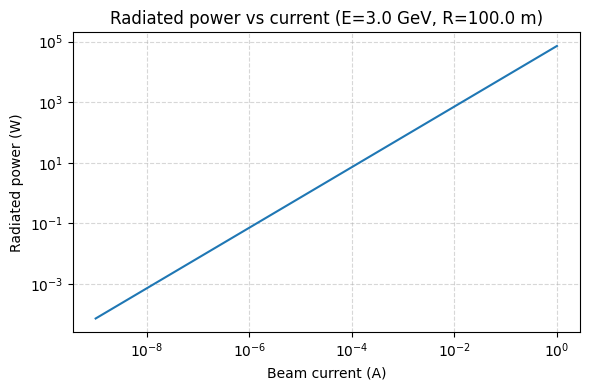

In [62]:
# Cell: Plot radiated power vs beam current for R = 100 m (3 GeV)
import numpy as np
import matplotlib.pyplot as plt

R = 100.0  # m
U0_keV = keV_factor * E_GeV**4 / R
U0_eV = U0_keV * 1e3

currs = np.logspace(-9, 0, 200)  # 1 nA .. 1 A
P_W = currs * U0_eV  # using notebook convention: P (W) = I(A) * U0(eV)

fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(currs, P_W)
ax.set_xlabel('Beam current (A)')
ax.set_ylabel('Radiated power (W)')
ax.set_title(f'Radiated power vs current (E={E_GeV} GeV, R={R} m)')
ax.grid(True, which='both', ls='--', alpha=0.5)

png_path = os.path.join(out_dir, f'P_vs_I_R{int(R)}.png')
fig.tight_layout()
fig.savefig(png_path)
print('Plot saved to:', png_path)
plt.show()


Reclaimed power (eta=75%) for E=3.0 GeV, R=100.0 m:
       I (A)          P_min (W)          P_max (W)
   1.000e-09       1.125000e-03       1.575000e-02
   1.000e-06       1.125000e+00       1.575000e+01
   1.000e-04       1.125000e+02       1.575000e+03
   1.000e-03       1.125000e+03       1.575000e+04
   1.000e-02       1.125000e+04       1.575000e+05
   1.000e-01       1.125000e+05       1.575000e+06
   1.000e+00       1.125000e+06       1.575000e+07

Plot saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\P_reclaimed_vs_I_R100.png

Plot saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\P_reclaimed_vs_I_R100.png


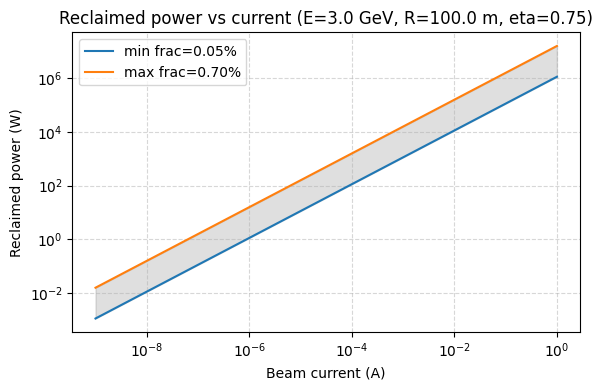

In [63]:
# Cell: Reclaimed power vs beam current for R = 100 m
# Assumes instantaneous acceleration by fraction f of nominal energy and 75% reclamation efficiency
min_frac = 0.0005  # 0.05%
max_frac = 0.007   # 0.7%
eta = 0.75  # reclamation efficiency

R = 100.0
E_eV = E_GeV * 1e9

currs = np.logspace(-9, 0, 200)

# deltaE in eV for min and max fractions
delta_min_eV = min_frac * E_eV
delta_max_eV = max_frac * E_eV

# Reclaimed power: P = I * deltaE_eV * eta (W)
P_min = currs * delta_min_eV * eta
P_max = currs * delta_max_eV * eta

# Print example numeric table for selected currents
sel_I = [1e-9, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
print(f'Reclaimed power (eta={eta*100:.0f}%) for E={E_GeV} GeV, R={R} m:')
print('{:>12} {:>18} {:>18}'.format('I (A)','P_min (W)','P_max (W)'))
for I in sel_I:
    Pmin = I * delta_min_eV * eta
    Pmax = I * delta_max_eV * eta
    print('{:12.3e} {:18.6e} {:18.6e}'.format(I, Pmin, Pmax))

# Plot band
fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(currs, P_min, label=f'min frac={min_frac*100:.2f}%')
ax.loglog(currs, P_max, label=f'max frac={max_frac*100:.2f}%')
ax.fill_between(currs, P_min, P_max, color='gray', alpha=0.25)
ax.set_xlabel('Beam current (A)')
ax.set_ylabel('Reclaimed power (W)')
ax.set_title(f'Reclaimed power vs current (E={E_GeV} GeV, R={R} m, eta={eta})')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()

png_path = os.path.join(out_dir, f'P_reclaimed_vs_I_R{int(R)}.png')
fig.tight_layout()
fig.savefig(png_path)
print('\nPlot saved to:', png_path)
plt.show()


Plot saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\compare_reclaim_vs_losses_variableGap_R100.png

I (A)   gap(m)   P_mag_var(W)   Reclaim_min(W)  Reclaim_max(W)  Radiated(W)  Total_var(W)
1.000e-09   0.0100   3.346883e+01   1.125000e-03   1.575000e-02   7.168500e-05   3.346890e+01
1.000e-06   0.0100   3.346883e+01   1.125000e+00   1.575000e+01   7.168500e-02   3.354051e+01
1.000e-04   0.0226   1.708126e+02   1.125000e+02   1.575000e+03   7.168500e+00   1.779811e+02
1.000e-03   0.0400   5.355013e+02   1.125000e+03   1.575000e+04   7.168500e+01   6.071863e+02
1.000e-02   0.0400   5.355013e+02   1.125000e+04   1.575000e+05   7.168500e+02   1.252351e+03
1.000e-01   0.0400   5.355013e+02   1.125000e+05   1.575000e+06   7.168500e+03   7.704001e+03
1.000e+00   0.0400   5.355013e+02   1.125000e+06   1.575000e+07   7.168500e+04   7.222050e+04


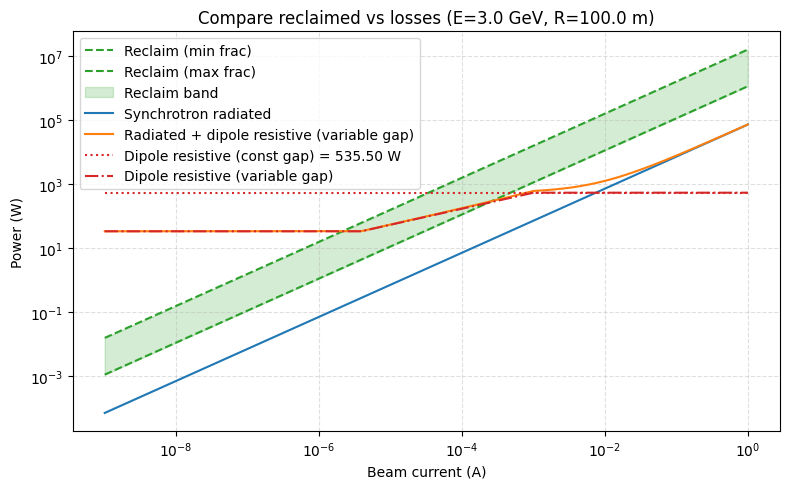

In [64]:
# Cell: Compare reclaimed power vs (synchrotron loss + dipole resistive power) for R=100 m
# Now model magnet gap shrinking with beam current (smaller currents -> smaller beam size -> smaller required gap)
R = 100.0
# re-compute U0
U0_keV = keV_factor * E_GeV**4 / R
U0_eV = U0_keV * 1e3

currs = np.logspace(-9, 0, 400)
P_rad = currs * U0_eV  # notebook convention: P (W) = I(A) * U0(eV)

# Reclaimed band (from earlier assumptions)
min_frac = 0.0005
max_frac = 0.007
eta = 0.75
E_eV = E_GeV * 1e9
P_reclaim_min = currs * (min_frac * E_eV) * eta
P_reclaim_max = currs * (max_frac * E_eV) * eta

# --- New: magnet gap model ---
# Reference gap at I0 (1 mA)
g0 = 0.04       # [m] gap at reference current
I0 = 1e-3       # [A] reference current for g0
s = 0.25        # scaling exponent: g ~ I^s (assumption)
min_gap = 0.01  # smallest practical gap [m]
max_gap = g0

# Compute gap vs current and clip to practical bounds
gI = g0 * (currs / I0)**s
gI = np.clip(gI, min_gap, max_gap)

# Magnetic field required (same as before)
B = E_GeV / (0.299792458 * R)

# Compute NI, coil current, resistive power per meter and total dipole resistive power as functions of current
NI_I = B * gI / mu0                # A-turns required
I_coil_I = NI_I / N_turns           # coil current for given turns
R_per_m = rho_cu / A_cu_examples[0] # using 10 mm^2 conductor here
P_per_m_I = I_coil_I**2 * R_per_m
L_dip = 2 * np.pi * R * f_dip
P_mag_I = P_per_m_I * L_dip        # total dipole resistive power vs beam current

# For comparison, compute constant dipole power using g0 (previous conservative estimate)
NI_const = B * g0 / mu0
I_coil_const = NI_const / N_turns
P_per_m_const = I_coil_const**2 * R_per_m
P_mag_const = P_per_m_const * L_dip

# Total loss with variable magnet power
P_total_var = P_rad + P_mag_I

# Plot comparison
fig, ax = plt.subplots(figsize=(8,5))
ax.loglog(currs, P_reclaim_min, ls='--', color='C2', label='Reclaim (min frac)')
ax.loglog(currs, P_reclaim_max, ls='--', color='C2', label='Reclaim (max frac)')
ax.fill_between(currs, P_reclaim_min, P_reclaim_max, color='C2', alpha=0.2, label='Reclaim band')
ax.loglog(currs, P_rad, color='C0', label='Synchrotron radiated')
ax.loglog(currs, P_total_var, color='C1', label='Radiated + dipole resistive (variable gap)')
ax.loglog(currs, np.full_like(currs, P_mag_const), color='C3', ls=':', label=f'Dipole resistive (const gap) = {P_mag_const:.2f} W')

# Also show dipole resistive curve vs current
ax.loglog(currs, P_mag_I, color='C3', ls='-.', label='Dipole resistive (variable gap)')

ax.set_xlabel('Beam current (A)')
ax.set_ylabel('Power (W)')
ax.set_title(f'Compare reclaimed vs losses (E={E_GeV} GeV, R={R} m)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()

png_path = os.path.join(out_dir, f'compare_reclaim_vs_losses_variableGap_R{int(R)}.png')
fig.tight_layout()
fig.savefig(png_path)
print('Plot saved to:', png_path)

# Print numeric table for selected currents including gap and dipole power
sel_I = [1e-9, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
print('\nI (A)   gap(m)   P_mag_var(W)   Reclaim_min(W)  Reclaim_max(W)  Radiated(W)  Total_var(W)')
for I in sel_I:
    # find nearest index in currs
    idx = np.argmin(np.abs(currs - I))
    gap = gI[idx]
    Pmagv = P_mag_I[idx]
    Pr_min = I * (min_frac * E_eV) * eta
    Pr_max = I * (max_frac * E_eV) * eta
    Prad = I * U0_eV
    Ptotv = Prad + Pmagv
    print(f'{I:8.3e}  {gap:7.4f}   {Pmagv:12.6e}   {Pr_min:12.6e}   {Pr_max:12.6e}   {Prad:12.6e}   {Ptotv:12.6e}')

plt.show()


Refined heatmap saved to: c:\Users\benfol\Documents\LW_windows\LW_integrator\reclaim_vs_losses_energy_grid_R100_refined.png

Energy (GeV)   I_cross_conservative (A)   I_cross_optimistic (A)
   0.100                 5.106e-07                5.286e-08
   0.122                 6.510e-07                6.216e-08
   0.148                 7.655e-07                7.925e-08
   0.180                 9.001e-07                9.319e-08
   0.220                 1.148e-06                1.096e-07
   0.267                 1.350e-06                1.397e-07
   0.325                 1.721e-06                1.643e-07
   0.396                 2.023e-06                2.095e-07
   0.482                 2.580e-06                2.463e-07
   0.587                 3.033e-06                3.141e-07
   0.715                 3.567e-06                3.693e-07
   0.870                 4.932e-06                4.342e-07
   1.059                 7.394e-06                5.537e-07
   1.290                 1.109

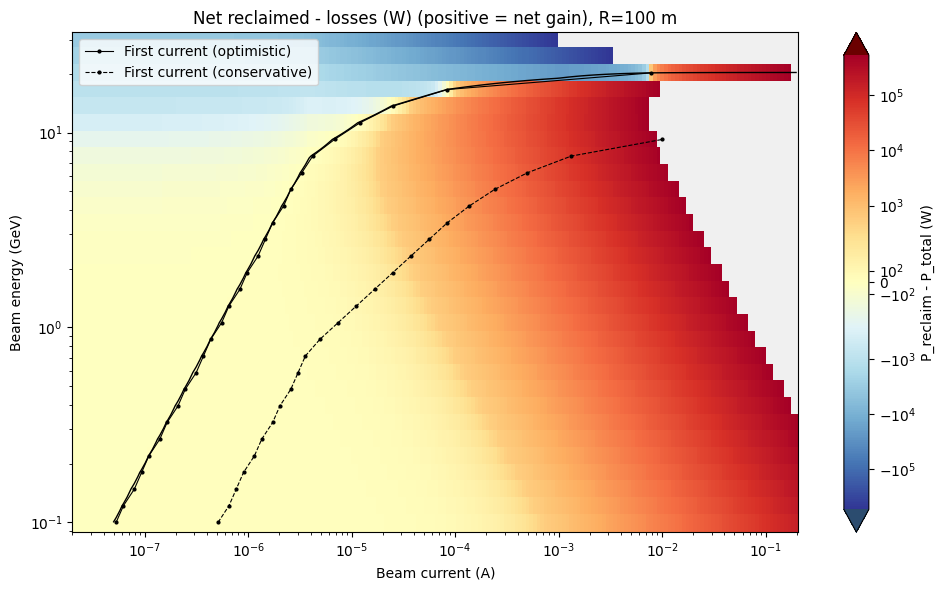

In [65]:
# Cell: Energy sweep (0.1 GeV -> 30 GeV) comparing reclaimed vs losses (2D grid)
# Currents extended down to tens of nanoamps and we show a min/max reclamation band
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

R = 100.0  # keep same radius for comparison
# Sweep energies from 0.1 GeV (100 MeV) to 30 GeV (log spacing)
energies = np.logspace(np.log10(0.1), np.log10(30.0), 30)
# Current grid: tens of nanoamps (~20 nA) to 200 mA (0.2 A)
currs = np.logspace(np.log10(2e-8), np.log10(2e-1), 200)

# Increased reclamation fractions (min & max band)
min_frac_new = 0.001   # 0.1% (conservative)
max_frac_new = 0.01    # 1.0% (optimistic)
eta = 0.75

# Pre-allocate result grids: rows=energies, cols=currents
# net_grid_min: conservative (min reclaim fraction)
# net_grid_max: optimistic (max reclaim fraction)
net_grid_min = np.zeros((len(energies), len(currs)))
net_grid_max = np.zeros_like(net_grid_min)

# Magnet gap model params (reuse earlier assumptions)
g0 = 0.04
I0 = 1e-3
s = 0.25
min_gap = 0.01
max_gap = g0

R_per_m = rho_cu / A_cu_examples[0]
L_dip = 2 * np.pi * R * f_dip

for i, E in enumerate(energies):
    U0_keV = keV_factor * E**4 / R
    U0_eV = U0_keV * 1e3
    P_rad = currs * U0_eV

    E_eV = E * 1e9
    P_reclaim_max = currs * (max_frac_new * E_eV) * eta
    P_reclaim_min = currs * (min_frac_new * E_eV) * eta

    # variable gap per current
    gI = g0 * (currs / I0)**s
    gI = np.clip(gI, min_gap, max_gap)

    B = E / (0.299792458 * R)
    NI_I = B * gI / mu0
    I_coil_I = NI_I / N_turns
    P_per_m_I = I_coil_I**2 * R_per_m
    P_mag_I = P_per_m_I * L_dip

    P_total = P_rad + P_mag_I

    net_grid_min[i, :] = P_reclaim_min - P_total
    net_grid_max[i, :] = P_reclaim_max - P_total

# For plotting, show optimistic (max) map but draw both contours to indicate band
net_grid_plot = net_grid_max

# Choose robust dynamic range: use 90th percentile, but allow SymLogNorm to show small values
abs_vals = np.abs(net_grid_plot[np.isfinite(net_grid_plot)])
if abs_vals.size == 0:
    vmax = 1.0
else:
    vmax = np.percentile(abs_vals, 90)
    if vmax <= 0:
        vmax = np.max(abs_vals) if np.max(abs_vals) > 0 else 1.0

vmin = -vmax

# SymLogNorm parameters: linthresh defines linear region around zero to show sign clearly
linthresh = max(vmax * 1e-3, 1e-3)   # slightly smaller linear threshold for better small-value detail
linscale = 1.0
norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)

# Mask data outside vmin/vmax to avoid extreme outliers dominating the map
masked = np.ma.masked_outside(net_grid_plot, vmin, vmax)

# Use a balanced diverging map that renders mid-values clearly
cmap = plt.get_cmap('RdYlBu_r')
# set a subtle color for masked values if supported
try:
    cmap = cmap.copy()
    cmap.set_bad('#f0f0f0')
    cmap.set_under('#2b4c6f')
    cmap.set_over('#6b0000')
except Exception:
    pass

# Plot heatmap with shading='auto' for grid compatibility
fig, ax = plt.subplots(figsize=(10,6))
pcm = ax.pcolormesh(currs, energies, masked, shading='auto', cmap=cmap, norm=norm)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Beam current (A)')
ax.set_ylabel('Beam energy (GeV)')
ax.set_title('Net reclaimed - losses (W) (positive = net gain), R=100 m')
cb = fig.colorbar(pcm, ax=ax, label='P_reclaim - P_total (W)', extend='both')

# draw zero contours for both optimistic (max) and conservative (min) reclaimation
try:
    CS_max = ax.contour(currs, energies, net_grid_max, levels=[0.0], colors='k', linewidths=1.0)
    CS_max.collections[0].set_label('Zero contour (optimistic: max reclaim > losses)')
    CS_min = ax.contour(currs, energies, net_grid_min, levels=[0.0], colors='k', linewidths=1.0, linestyles='--')
    CS_min.collections[0].set_label('Zero contour (conservative: min reclaim > losses)')
except Exception:
    pass

# crossing current markers for both bounds
I_cross_max = np.full(len(energies), np.nan)
I_cross_min = np.full(len(energies), np.nan)
for i in range(len(energies)):
    arr_max = net_grid_max[i, :]
    pos_idx_max = np.where(arr_max > 0)[0]
    if pos_idx_max.size:
        I_cross_max[i] = currs[pos_idx_max[0]]
    arr_min = net_grid_min[i, :]
    pos_idx_min = np.where(arr_min > 0)[0]
    if pos_idx_min.size:
        I_cross_min[i] = currs[pos_idx_min[0]]

valid_max = ~np.isnan(I_cross_max)
valid_min = ~np.isnan(I_cross_min)
if np.any(valid_max):
    ax.plot(I_cross_max[valid_max], energies[valid_max], 'k.-', lw=0.8, ms=4, label='First current (optimistic)')
if np.any(valid_min):
    ax.plot(I_cross_min[valid_min], energies[valid_min], 'k.--', lw=0.8, ms=4, label='First current (conservative)')

ax.legend()

png_path = os.path.join(out_dir, 'reclaim_vs_losses_energy_grid_R100_refined.png')
fig.tight_layout()
fig.savefig(png_path, dpi=200)
print('Refined heatmap saved to:', png_path)

# Print a small table of crossing currents for both min/max reclaim fractions
print('\nEnergy (GeV)   I_cross_conservative (A)   I_cross_optimistic (A)')
for E, Imin, Imax in zip(energies, I_cross_min, I_cross_max):
    smin = 'N/A' if np.isnan(Imin) else f'{Imin:8.3e}'
    smax = 'N/A' if np.isnan(Imax) else f'{Imax:8.3e}'
    print(f'{E:8.3f}    {smin:>22}   {smax:>22}')

plt.show()
